# 🧼 Prétraitement des données

**Objectif**: Transformer le jeu de données brut, suite à l'analyse exploratoire, en un format **propre et exploitable** pour l'entraînement de modèles de machine learning.

Les étapes suivantes seront réalisées:

1. **Nettoyage initial**:
   - Suppression des colonnes inutiles ou peu informatives
   - Gestion des valeurs manquantes
   - Identification et traitement des valeurs aberrantes (outliers)

2. **Transformation des variables**:
   - Encodage des variables catégorielles
   - Normalisation des variables numériques
   - Création de nouvelles variables pertinentes (feature engineering)

3. **Préparation finale**:
   - Validation de la qualité des données transformées
   - Sauvegarde du dataset nettoyé pour la modélisation

Ce prétraitement est indispensable pour garantir la qualité, la robustesse et la performance des modèles qui seront entraînés par la suite.



In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pickle
import os

sns.set_theme(style="whitegrid")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

PROJECT_ROOT = os.environ.get("GITHUB_WORKSPACE") if "GITHUB_WORKSPACE" in os.environ else os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"Using PROJECT_ROOT: {PROJECT_ROOT}")


Using PROJECT_ROOT: /Users/ivan.gallo/Courses/AI-Bois-de-Boulonge/Winter-2025/Supervised Learning/Project/time_resolution_ml


#### Nettoyage initial

> Dans cette étape fondamentale, nous allons procéder au nettoyage des données brutes pour éliminer les éléments qui pourraient compromettre la qualité de notre analyse et de nos modèles prédictifs.


In [72]:

df = pd.read_csv(os.path.join(PROJECT_ROOT, "data", "raw", "trouble_tickets.csv"))
df.head()

,ticketId,category,creationDate,device,issueType,priority,numberAffectedUsers,reportedBy,severity,status,resolutionDate,customer
0,T4347360,Wireless Network,2025-01-01 00:10:00,Gateway-CHI-V6500-WH892,[ROOT] Configuration Error on Network,Critical,NaN,Joseph Lee,Unknown,Closed,2025-01-01 09:00:00,9905095026
1,T4347363,Wireless Network,2025-01-01 00:20:00,Modem-NYC-S8500-YE944,Authentication Failure on Backup Link,Critical,NaN,Joseph Lee,Unknown,Closed,2025-01-01 05:52:28,9905095026
2,T4347366,Wireless Network,2025-01-01 00:25:00,Gateway-CHI-V6500-WH892,Routing Loop on Firewall,Critical,NaN,Joseph Lee,Unknown,Closed,2025-01-01 09:00:00,9905095026
3,T4347375,Wireless Network,2025-01-01 00:40:00,Gateway-CHI-V6500-WH892,Hardware Failure on Router,Critical,NaN,Joseph Lee,Unknown,Closed,2025-01-01 09:00:00,9905095026
4,T4347376,Wireless Network,2025-01-01 00:40:00,Hub-SEA-M3000-SJ762,Connection Down on Circuit,Critical,NaN,Joseph Lee,Unknown,Closed,2025-01-01 09:00:00,9902641725


In [73]:
df = df.dropna(subset=["resolutionDate"])
df = df.drop(columns=['numberAffectedUsers', 'reportedBy'])

In [74]:
def get_missing_values(data):
  missing_val = df.isnull().sum()
  missing_perc = df.isnull().mean() * 100
  missing_df = pd.DataFrame({
    'Missing Values': missing_val,
    'Percentage (%)': missing_perc
  })
  return missing_df.sort_values('Percentage (%)', ascending=False)



In [75]:
display(get_missing_values(df))

,Missing Values,Percentage (%)
ticketId,0,0.0
category,0,0.0
creationDate,0,0.0
device,0,0.0
issueType,0,0.0
priority,0,0.0
severity,0,0.0
status,0,0.0
resolutionDate,0,0.0
customer,0,0.0


In [76]:
dup_count = df.duplicated(subset="ticketId").sum()
print("Nombre de doublons sur ticketId :", dup_count)

if dup_count:
    df = (df.drop_duplicates(subset="ticketId", keep="last"))

Nombre de doublons sur ticketId : 0


#### Transformation des données temporelles

Conversion et calcul du temps de résolution:

>Nous commençons par convertir les colonnes de date en format datetime pour faciliter les manipulations temporelles. Cette conversion nous permet ensuite de calculer la **variable cible** de notre modèle : le temps de résolution en heures.

In [77]:
# Convert timestamp columns to datetime
df['creationDate'] = pd.to_datetime(df['creationDate'])
df['resolutionDate'] = pd.to_datetime(df['resolutionDate'])

# Calculate resolution time in hours
df['resolution_time'] = (df['resolutionDate'] - df['creationDate']).dt.total_seconds() / 3600

**Extraction de caractéristiques temporelles:**

> Nous enrichissons ensuite le dataset avec des variables dérivées des dates, qui pourront servir de prédicteurs pertinents :

In [78]:
df['creation_day_of_week'] = df['creationDate'].dt.dayofweek
df['creation_month'] = df['creationDate'].dt.month
df['is_weekend'] = df['creation_day_of_week'].isin([5, 6]).astype(int)

In [79]:
df.head()

,ticketId,category,creationDate,device,issueType,priority,severity,status,resolutionDate,customer,resolution_time,creation_day_of_week,creation_month,is_weekend
0,T4347360,Wireless Network,2025-01-01 00:10:00,Gateway-CHI-V6500-WH892,[ROOT] Configuration Error on Network,Critical,Unknown,Closed,2025-01-01 09:00:00,9905095026,8.833333,2,1,0
1,T4347363,Wireless Network,2025-01-01 00:20:00,Modem-NYC-S8500-YE944,Authentication Failure on Backup Link,Critical,Unknown,Closed,2025-01-01 05:52:28,9905095026,5.541111,2,1,0
2,T4347366,Wireless Network,2025-01-01 00:25:00,Gateway-CHI-V6500-WH892,Routing Loop on Firewall,Critical,Unknown,Closed,2025-01-01 09:00:00,9905095026,8.583333,2,1,0
3,T4347375,Wireless Network,2025-01-01 00:40:00,Gateway-CHI-V6500-WH892,Hardware Failure on Router,Critical,Unknown,Closed,2025-01-01 09:00:00,9905095026,8.333333,2,1,0
4,T4347376,Wireless Network,2025-01-01 00:40:00,Hub-SEA-M3000-SJ762,Connection Down on Circuit,Critical,Unknown,Closed,2025-01-01 09:00:00,9902641725,8.333333,2,1,0


##### Détection des outliers par la méthode de l'IQR (Intervalle Interquartile):

> Nous utilisons l'approche statistique basée sur l'IQR, considérant comme aberrantes les valeurs situées à plus de 1.5 × IQR des quartiles Q1 et Q3 :

In [80]:
# Identification des valeurs aberrantes
Q1 = df['resolution_time'].quantile(0.25)
Q3 = df['resolution_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['resolution_time'] < lower_bound) | (df['resolution_time'] > upper_bound)]
print(f"Nombre de valeurs aberrantes pour le temps de résolution : {len(outliers)}")
print(f"Pourcentage de valeurs aberrantes : {(len(outliers) / len(df)) * 100:.2f}%")

Nombre de valeurs aberrantes pour le temps de résolution : 158
Pourcentage de valeurs aberrantes : 3.34%


##### Traitement des valeurs aberrantes par remplacement

> Nous créons une copie du dataframe pour préserver les données originales, puis remplaçons les valeurs aberrantes par la médiane, une mesure robuste de tendance centrale


In [81]:
# Application du traitement des valeurs aberrantes au dataset
df_cleaned = df.copy()

median_resolution_time = df_cleaned['resolution_time'].median()

# Remplacer les valeurs aberrantes par la median
df_cleaned.loc[df_cleaned['resolution_time'] < lower_bound, 'resolution_time'] = median_resolution_time
df_cleaned.loc[df_cleaned['resolution_time'] > upper_bound, 'resolution_time'] = median_resolution_time

print(f"Après traitement - Min: {df_cleaned['resolution_time'].min()}, Max: {df_cleaned['resolution_time'].max()}")

Après traitement - Min: 1.903888888888889, Max: 64.69194444444445


##### Visualisation de l'impact du traitement des valeurs aberrantes
> Pour évaluer l'efficacité de notre traitement des valeurs aberrantes, nous comparons visuellement la distribution du temps de résolution après intervention :


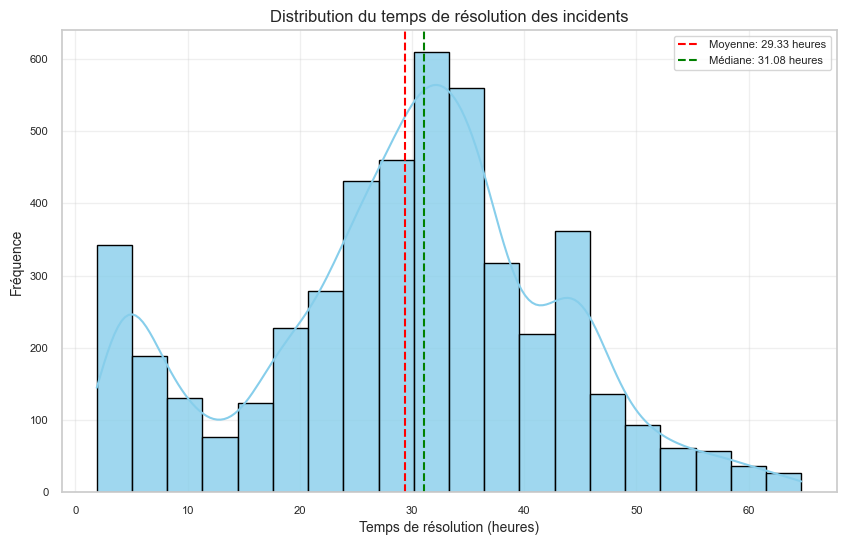

In [82]:
df_rt = df_cleaned['resolution_time']
rt_mean = df_rt.mean()
rt_median = df_rt.median()

plt.figure(figsize=(10, 6))
sns.histplot(df_rt, bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Distribution du temps de résolution des incidents')
plt.xlabel('Temps de résolution (heures)')
plt.ylabel('Fréquence')
plt.axvline(rt_mean, color='red', linestyle='--', label=f'Moyenne: {rt_mean:.2f} heures')
plt.axvline(rt_median, color='green', linestyle='--', label=f'Médiane: {rt_median:.2f} heures')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

##### Encodage des variables catégorielles

> Application de l'encodage par Label Encoder au quatre variables catégorielles principales :
> `issueType` : type de problème reporté
> `category` : catégorie du ticket
> `priority` : niveau de priorité attribué
> `severity` : degré de gravité/impact


In [83]:
# Limpiar espacios en blanco de la columna issueType
df_cleaned['issueType'] = df_cleaned['issueType'].str.strip()

categorical_cols = ['issueType', 'category', 'priority', 'severity']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = le


##### Persistance des encodeurs

> Ce bloc sauvegarde les encodeurs d'étiquettes (LabelEncoders) dans un fichier pickle pour une utilisation ultérieure. Cela garantit que la même transformation appliquée pendant l'entraînement sera utilisée lors de la prédiction, assurant ainsi la cohérence dans l'encodage/décodage des variables catégorielles.



In [84]:
# Sauvegarde pour utilisation future
with open(os.path.join(PROJECT_ROOT, "models", "transformers", "label_encoders.pkl"), 'wb') as f:
    pickle.dump(label_encoders, f)

#### Préparation finale

##### Calcul de la matrice de corrélation

> Cette cellule calcule la matrice de corrélation entre les variables numériques et catégorielles encodées du jeu de données. Cette analyse nous permet d'identifier les relations linéaires entre les différentes caractéristiques et le temps de résolution.


In [85]:
correlation_matrix = df_cleaned[['resolution_time', 'category','severity', 'issueType', 'priority', 'creation_day_of_week', 'creation_month', 'is_weekend']].corr()
display(correlation_matrix)

,resolution_time,category,severity,issueType,priority,creation_day_of_week,creation_month,is_weekend
resolution_time,1.000000,-0.365367,0.030258,0.111931,0.768150,0.142696,0.333608,0.147683
category,-0.365367,1.000000,0.054094,0.018247,-0.310798,-0.101908,-0.327847,-0.156152
severity,0.030258,0.054094,1.000000,-0.016444,0.059977,0.031527,-0.005586,0.053835
issueType,0.111931,0.018247,-0.016444,1.000000,0.084270,-0.009277,0.064737,-0.002301
priority,0.768150,-0.310798,0.059977,0.084270,1.000000,0.167571,0.364045,0.158209
creation_day_of_week,0.142696,-0.101908,0.031527,-0.009277,0.167571,1.000000,0.173352,0.802495
creation_month,0.333608,-0.327847,-0.005586,0.064737,0.364045,0.173352,1.000000,0.241737
is_weekend,0.147683,-0.156152,0.053835,-0.002301,0.158209,0.802495,0.241737,1.000000


##### Visualisation de la matrice de corrélation

> Cette cellule crée une représentation visuelle de la matrice de corrélation sous forme de heatmap.


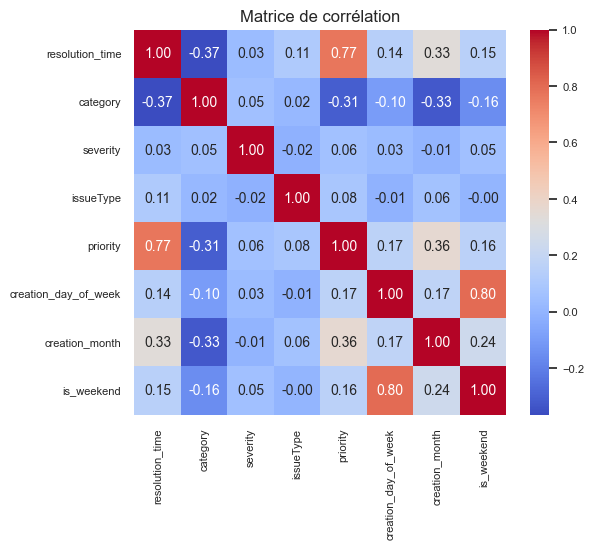

In [86]:
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

##### Sauvegarde du jeu de données nettoyé

> Cette cellule enregistre le jeu de données nettoyé et transformé dans un fichier CSV pour une utilisation ultérieure dans les phases de développement du modèle.


In [87]:
# Saving the cleaned dataset
df_cleaned.to_csv(os.path.join(PROJECT_ROOT, "data", "processed", "clean_trouble_tickets.csv"), index=False)


## ✅ Conclusion du prétraitement

Le jeu de données a été préparé avec soin :

- Les variables inutiles ont été éliminées
- Les valeurs manquantes ont été traitées ou filtrées
- Les dates ont été converties et enrichies (jour de semaine, mois, week-end)
- Les variables catégorielles ont été encodées
- La variable cible `resolution_time` a été correctement générée

➡️ Le dataset est maintenant prêt pour l’étape suivante : **l'entraînement des modèles de régression**.
